<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.852 · Tipología y ciclo de vida de los datos · PRA1</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRACTICA 1: Web scraping

## 1. Settings

In this first section we are going to describe and explain the main libraries used in the notebook and why we need them:

- `requests`:
	Python library that allows the user to send HTTP/1.1 requests easily (POST, GET, PUT, etc.). 
	It is beeing used to get the main content of the URLs used (GET request). 
 
 
- `builtwith`:
	Python library that detects the technology used by a website (Apache, JQuery, Wordpress),
	the servers and several relevant information.  
	It will be applied for detecting teh etchnology used for developing the web's design, as it will
	define the Web Scraping style that will be necessary to apply.
    
    
- `beautifulsoup4`:
	Python library to scrape information from web pages easily through it HTML or XML file.
	It is the main library for scraping all the information from the main URL.
    
    
- `python-whois`:
	Python library that produces parsed WHOIS data for a given URL to be able to extract data for all
	the popular TLDs (com, org, net, …). Also it enables the query of a WHOIS server directly instead of
	going through an intermediate web service.
	This library allows us to know the owner of the webpage we want to scrape and to see if there are any
	scraping blockers.
    
    
- `re`:
	Python library for creating regular expressions to search with.
	It will helps us to extract the relevant information of the HTML's text.
    
    
- `pandas`:
	Python package that provides fast, flexible, and expressive data structures designed to make working with
	"relational" or "labeled" data easy and intuitive.
	This package will be fundamental to develop the final steps of this proyect by creating and exporting the
	final dataset.
 
 
- `session-info`:
    Python library that outputs version information for modules loaded in the current session, Python, the OS,
    and the CPU.
    As extracting a "requirements.txt" file using pip freeze would bring too much innecessary data, this library
    will solve the problem by just showing the modeles beeing used in this notebook and osme other relevant dependencies.

### 1.1 Installations

If any of the forementioned libraries is not installed in the user's machine, this piece of code will installed them:

In [1]:
!pip install requests
!pip install builtwith
!pip install beautifulsoup4
!pip install python-whois
!pip install session-info

### 1.2 Imports

Once the libraries are all installed in the machine, it is time to import them to this notebook:

In [2]:
import requests
import builtwith
import whois
from bs4 import BeautifulSoup
import re
import pandas as pd
import session_info

# Python file with all the common function used in chapter 3.
import utils     

## 2. Information about the main URL

In [3]:
# Let's check the technologies of the webpage we want to scrap
builtwith.parse('https://www.expatistan.com/cost-of-living/country/ranking')

{'web-servers': ['Nginx'], 'advertising-networks': ['Google AdSense']}

In [4]:
# Let's see the content of the webpage
page = requests.get("https://www.expatistan.com/cost-of-living/country/ranking")

In [5]:
# Let's see the owner of the domain
print(whois.whois("expatistan.com"))

{
  "domain_name": "EXPATISTAN.COM",
  "registrar": "NameCheap, Inc.",
  "whois_server": "whois.namecheap.com",
  "referral_url": null,
  "updated_date": "2018-07-27 13:28:22",
  "creation_date": "2009-08-16 09:25:31",
  "expiration_date": "2023-08-16 09:25:31",
  "name_servers": [
    "NS-1210.AWSDNS-23.ORG",
    "NS-1673.AWSDNS-17.CO.UK",
    "NS-383.AWSDNS-47.COM",
    "NS-667.AWSDNS-19.NET",
    "NS1.LINODE.COM",
    "NS2.LINODE.COM",
    "NS3.LINODE.COM",
    "NS4.LINODE.COM",
    "NS5.LINODE.COM"
  ],
  "status": "clientTransferProhibited https://icann.org/epp#clientTransferProhibited",
  "emails": "abuse@namecheap.com",
  "dnssec": "unsigned",
  "name": null,
  "org": null,
  "address": null,
  "city": null,
  "state": null,
  "registrant_postal_code": null,
  "country": null
}


In [11]:
# Let's analyse the structure of the html code and show a bit of it
soup = BeautifulSoup(page.content)
print(soup.prettify()[:1900])

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="content-type"/>
  <link href="https://www.expatistan.com/cost-of-living/country/ranking" hreflang="en" rel="alternate"/>
  <link href="https://www.expatistan.com/es/costo-de-vida/pais/ranking" hreflang="es" rel="alternate"/>
  <link href="https://www.expatistan.com/pt/custo-de-vida/pais/classificacao" hreflang="pt" rel="alternate"/>
  <title>
   Cost of Living Ranking by countries. Updated Apr 2023
  </title>
  <meta content="Ranking of the the cheapest and the most expensives countries in the world with current prices as of Apr 2023." name="description"/>
  <meta content="Cost of Living Ranking by countries. Updated Apr 2023" property="og:title"/>
  <meta content="website" property="og:type"/>
  <meta content="Ranking of the the cheapest and the most expensives countries in the world with current prices as of Apr 2023." property="og:description"/>
  <meta content="//d2y05869ftj0yg.cloudfron

In [12]:
# Let's see this sessions dependencies and library versions
session_info.show()

## 2.1 User agent

https://www.expatistan.com/robots.txt

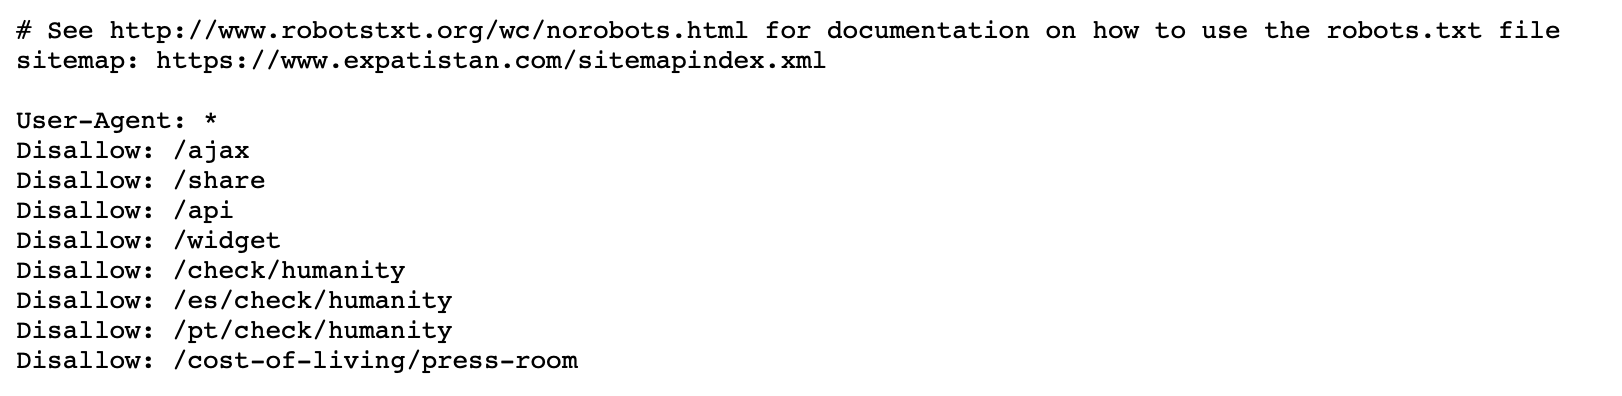

Podemos ver que el user agent que emplea python para acceder a la URL no está excluido en el dominio del archivo robots de la página, por lo que no hay problema en la configuración por defecto de python para hacer web scraping.

## 3. Web Scraping 

### 3.1 Creation of the main class for the Country Web Scraping

In [15]:
class ExpatistanCountryScraper():
    """
    Class to carry on the Web Scraping of the Country links from the original URL 
    www.expatistan.com
    ...

    Private Methods
    ---------------
        __init__(url):
            Constructor of the class.
        __scraping_single_country(self, url, country):
            Extract the relevant information of a single Country link from its HTML file
    
    Public Methods
    --------------
        scraping():
            Main function of the class that starts the web scraping  
    """
    
    def __init__(self):
        """
        Constructs all the necessary attributes for the Expatistan Web Scraper.
            
        """
        self.original_url = "https://www.expatistan.com/cost-of-living/country/ranking"
        
        # The dataset, as a first instance, it is going to be stored as a JSON variable
        self.dataset =  {
            "Ranking position": [],
            'Country': [],
            'Category': [],
            'Items': [],
            'Original Currency': [],
            'Original Currency Value': [],
            'Exchanged Currency': [],
            'Exchanged Currency Value': []
        }
         
        
    def __scraping_single_country(self, url, country):
        """
        Runs the Web Scraping of a particular Country URL

        Parameters
        ----------
            self (class): Instance of the class that is invoking the method
            link (str): link to the Country's webpage
            country (str): name of the Country to be scraped

        """
        
        # First we need to get the HTML file for this link
        country_html = utils.get_HTML(url)
        
        # Then we get the Ranking position of the Country
        pos = utils.get_ranking_pos(country_html, 2)

        # All the information is under <table> tag, with class: comparison single-city
        table_tags = country_html.find('table', {'class': 'comparison single-city'})

        # Setting the common variables for the scraping
        current_category = ""
        current_orig_currency = ""
        
        # For every <tr> tag
        for tr in table_tags.findAll("tr"):
            # If the tag has the class = "categoryHeader"
            if "categoryHeader" in tr.get("class", []):
                # We get the first <th> tag 
                first_th_tag = tr.find("th")
                # And extract its text as the Category of the Dataset's row
                current_category = first_th_tag.text
                
            else:
                # If not, it means it has <td> tags and we retrieve them all
                td_tags = tr.findAll("td")
                
                # Depending on how many <td> tags, we scrape different information
                # 2 tags means that we can retrive the currency being used in the Country
                if len(td_tags) == 2:
                    currency = tr.find("td")
                    current_orig_currency = currency.text

                # 3 tags means we are scraping an european country that uses Euros as currency, 
                # so the exchange common currency is going to be the same one
                elif len(td_tags) == 3: 
                    self.dataset['Ranking position'].append(pos)
                    self.dataset['Country'].append(country)
                    self.dataset['Category'].append(current_category)
                    self.dataset['Items'].append(td_tags[1].text.strip())
                    self.dataset['Original Currency'].append("EUR")
                    self.dataset['Original Currency Value'].append((td_tags[2].text.strip()))
                    self.dataset['Exchanged Currency'].append("EUR")
                    self.dataset['Exchanged Currency Value'].append((td_tags[2].text.strip()))
                
                # 4 tags means we are scraping a Country which currency is not Euros,
                # so we scrape its own currency and its exchanged value in Euros
                elif len(td_tags) == 4:
                    self.dataset['Ranking position'].append(pos)
                    self.dataset['Country'].append(country)
                    self.dataset['Category'].append(current_category)
                    self.dataset['Items'].append(td_tags[1].text.strip())
                    self.dataset['Original Currency'].append(current_orig_currency)
                    self.dataset['Original Currency Value'].append(td_tags[2].text.strip())
                    self.dataset['Exchanged Currency'].append("EUR")
                    self.dataset['Exchanged Currency Value'].append(td_tags[3].text.strip())
                    
        

    def scraping(self):
        """
        Main method of the class that starts the Web Scraping of the main webpage

        Parameters
        ----------
            self (class): Instance of the class that is invoking the method

        """
        # 1. Get the original HTML file using Beautiful Soup
        html = utils.get_HTML(self.original_url)
        
        # 2. Get all the Country links to scrape 
        country_urls = utils.get_links(html, False)
        
        # 3. For each country, let's scrape all the information
        print("Starting the Country's Web Scraping!\n")
        for url in country_urls:
            # From the link, we get the last 
            country = re.search(r"country/([^/?]*)", url).group(1)
            country = re.sub("-", " ", country).title()
            print("Scraping country: " + country)
            self.__scraping_single_country(url, country)

        # 4. Finally, we save all the information ina CSV file
        print("\nScraping finished!")
        utils.saving("../dataset/cost_of_living_countries.csv", self.dataset)

#### 3.1.1 Scraping of Cost of Living per Country

In [16]:
scraper = ExpatistanCountryScraper()
scraper.scraping()

Starting the Country's Web Scraping!

Scraping country: Bermuda
Scraping country: Singapore
Scraping country: Switzerland
Scraping country: Cayman Islands
Scraping country: Bahamas
Scraping country: Hong Kong
Scraping country: Ireland
Scraping country: Denmark
Scraping country: United States
Scraping country: Norway
Scraping country: Netherlands
Scraping country: Luxembourg
Scraping country: Australia
Scraping country: New Zealand
Scraping country: Qatar
Scraping country: United Kingdom
Scraping country: Israel
Scraping country: Canada
Scraping country: Germany
Scraping country: Finland
Scraping country: Belgium
Scraping country: Sweden
Scraping country: Austria
Scraping country: France
Scraping country: Japan
Scraping country: United Arab Emirates
Scraping country: Malta
Scraping country: South Korea
Scraping country: Macao
Scraping country: Uruguay
Scraping country: Italy
Scraping country: Panama
Scraping country: Dominican Republic
Scraping country: Kuwait
Scraping country: Palestin

### 3.2 Creation of the main class for the City Web Scraping

In [13]:
class ExpatistanCityScraper():
    """
    Class to carry on the Web Scraping of the cities links from the original URL 
    www.expatistan.com
    ...

    Private Methods
    ---------------
        __init__(url):
            Constructor of the class.
        __scraping_single_country(self, url, country):
            Extract the relevant information of a single Country link from its HTML file
    
    Public Methods
    --------------
        scraping():
            Main function of the class that starts the web scraping  
    """
    
    def __init__(self):
        """
        Constructs all the necessary attributes for the Expatistan Web Scraper.
            
        """
        self.original_url = "https://www.expatistan.com/cost-of-living/index?ranking=1"
        
        # The dataset, as a first instance, it is going to be stored as a JSON variable
        self.dataset =  {
            "Ranking position": [],
            'Country': [],
            'City': [],
            'State': [],
            'Category': [],
            'Items': [],
            'Original Currency': [],
            'Original Currency Value': [],
            'Exchanged Currency': [],
            'Exchanged Currency Value': []
        }
    
    
    def __scraping_single_city(self, url):
        """
        Runs the Web Scraping of a particular city URL

        Parameters
        ----------
            self (class): Instance of the class that is invoking the method
            url (str): link to the city's webpage

        """
        
        # First we need to get the HTML file for this link
        city_html = utils.get_HTML(url)
        
        # Then we get the Ranking position of the Country
        pos = utils.get_ranking_pos(city_html, 3)

        # All the information is under <table> tag, with class: comparison single-city
        table_tags = city_html.find('table', {'class': 'comparison single-city'})
        
        
        # Setting the common variables for the scraping
        current_category = ""
        current_orig_currency = ""
        current_country = ""
        current_city = ""
        current_state = ""
        
        # Setting the variable city, country and state (if exists)
        location = city_html.find('span', {'class': 'city-2'}).text.split(",")
        current_city = location[0].strip()
        if len(location) == 1:
            current_state = "No state"
            current_country = current_city
        elif len(location) == 2:
            current_state = "No state"
            current_country = location[1].strip()
        else:
            current_state = location[1].strip()
            current_country = location[2].strip()
        
        
        for tr in table_tags.findAll("tr"):
            # If the tag has the class = "categoryHeader"
            if "categoryHeader" in tr.get("class", []):
                # We get the first <th> tag 
                first_th_tag = tr.find("th")
                # And extract its text as the Category of the Dataset's row
                current_category = first_th_tag.text
                
            else:
                # If not, it means it has <td> tags and we retrieve them all
                td_tags = tr.findAll("td")
                
                # Depending on how many <td> tags, we scrape different information
                # 2 tags means that we can retrive the currency being used in the city
                if len(td_tags) == 2:
                    currency = tr.find("td")
                    current_orig_currency = currency.text
            
                # 3 tags means we are scraping an european city that uses Euros as local currency, 
                # so the exchange common currency is going to be the same one
                elif len(td_tags) == 3: 
                    self.dataset['Ranking position'].append(pos)
                    self.dataset['Country'].append(current_country)
                    self.dataset['City'].append(current_city)
                    self.dataset['State'].append(current_state)
                    self.dataset['Category'].append(current_category)
                    self.dataset['Items'].append(td_tags[1].text.strip())
                    self.dataset['Original Currency'].append("EUR")
                    self.dataset['Original Currency Value'].append("Not defined"
                                                                   if "-" in td_tags[2].text.strip()
                                                                   else td_tags[2].text.strip())
                    self.dataset['Exchanged Currency'].append("EUR")
                    self.dataset['Exchanged Currency Value'].append("Not defined"
                                                                   if "-" in td_tags[2].text.strip()
                                                                   else td_tags[2].text.strip())
                
                # 4 tags means we are scraping a Country which currency is not Euros,
                # so we scrape its own currency and its exchanged value in Euros
                elif len(td_tags) == 4:
                    self.dataset['Ranking position'].append(pos)
                    self.dataset['Country'].append(current_country)
                    self.dataset['City'].append(current_city)
                    self.dataset['State'].append(current_state)
                    self.dataset['Category'].append(current_category)
                    self.dataset['Items'].append(td_tags[1].text.strip())
                    self.dataset['Original Currency'].append(current_orig_currency)
                    self.dataset['Original Currency Value'].append("Not defined"
                                                                   if "-" in td_tags[2].text.strip()
                                                                   else td_tags[2].text.strip())
                    self.dataset['Exchanged Currency'].append("EUR")
                    self.dataset['Exchanged Currency Value'].append("Not defined"
                                                                   if "-" in td_tags[3].text.strip()
                                                                   else td_tags[3].text.strip())
        
    def scraping(self):
        """
        Main method of the class that starts the Web Scraping of the main webpage

        Parameters
        ----------
            self (class): Instance of the class that is invoking the method

        """
        # 1. Get the original HTML file using Beautiful Soup
        html = utils.get_HTML(self.original_url)
        
        # 2. Get all the Country links to scrape 
        cities_urls = utils.get_links(html, True)
        
        # 3. For each country, let's scrape all the information
        print("Starting the City's Web Scraping!\n")
        for url in cities_urls:
            # From the link, we get the last 
            city = re.search(r"living/([^/?]*)", url).group(1)
            city = re.sub("-", " ", city).title()
            print("Scraping city: " + city)
            self.__scraping_single_city(url)

        # 4. Finally, we save all the information ina CSV file
        print("\nScraping finished!")
        utils.saving("../dataset/cost_of_living_cities.csv", self.dataset)

#### 3.2.1 Scraping of Cost of Living per City

In [14]:
scraper = ExpatistanCityScraper()
scraper.scraping()

Starting the City's Web Scraping!

Scraping city: New York City
Scraping city: Grand Cayman
Scraping city: Singapore
Scraping city: Hamilton Bermuda
Scraping city: Maui
Scraping city: Zurich
Scraping city: Geneva
Scraping city: Basel
Scraping city: Lausanne
Scraping city: Miami
Scraping city: San Francisco
Scraping city: Lugano
Scraping city: Oakland California
Scraping city: London
Scraping city: Los Angeles
Scraping city: Washington D C
Scraping city: Honolulu
Scraping city: Denver
Scraping city: Hong Kong
Scraping city: Dublin
Scraping city: Dallas
Scraping city: Seattle
Scraping city: San Diego
Scraping city: San Jose California
Scraping city: Philadelphia
Scraping city: Copenhagen
Scraping city: Austin
Scraping city: Tampa
Scraping city: Nassau
Scraping city: Vancouver
Scraping city: Amsterdam
Scraping city: Atlanta
Scraping city: Sydney
Scraping city: Toronto
Scraping city: Raleigh North Carolina
Scraping city: Phoenix
Scraping city: Sacramento
Scraping city: Auckland
Scraping ci